# Data analysis for HRV and MET

Processing data received through MAXIM REFDES103 to use in training neural network

## Imports and system

### Imports for the whole file

In [14]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np 
from scipy.fft import rfft, rfftfreq
from scipy.fft import fft, fftfreq
from scipy.interpolate import CubicSpline
import csv
import os

### Data extraction through dataframe for the whole file

Plus, some plots to be able to see what's happening

In [15]:
def data_plot(df): 

    #get timestamps
    timestamp = df['sample_time']

    #get rr intervals 
    rr = df['rr']

    #get magnitude of PPG measurement
    amp = df['green']
    amp_array = amp.to_numpy()

    max = np.max(amp_array)
    min = np.min(amp_array)

    amp_array_norm = (amp_array - min) / (max - min)

    #get synthetic acceleration 
    acx = df['acceleration_x']
    acy = df['acceleration_y']
    acz = df['acceleration_z']

    syn_ac = np.square(acx) + np.square(acy) + np.square(acz)
    syn_ac = np.power(syn_ac, 1/2)

    #get rr without zeroes
    rr_nz = rr[rr!=0]
    rr_array = rr_nz.to_numpy()

    #get calories
    cal = df['calorie']

    #plot data
    figure, axis = plt.subplots(3)
    axis[0].plot(timestamp, amp_array_norm)
    axis[1].plot(timestamp, rr)
    axis[2].plot(timestamp, syn_ac)

    return timestamp, amp_array_norm, rr_array, syn_ac, cal


## HRV analysis



### Denoising data

In [16]:
def denoise(rr_array): 

    #denoising through IQR 
    Q1 = np.percentile(rr_array, 25)
    Q3 = np.percentile(rr_array, 75)

    IQR = Q3 - Q1

    #print(IQR)

    iqr_min = Q1 - 1.5*IQR
    iqr_max = Q3 + 1.5*IQR

    rr_array_clean = rr_array[(rr_array <iqr_max) & (rr_array>iqr_min)]

    return rr_array_clean

### Time analysis methods

#### RMSSD

In [17]:
def RMSSD_func(rr_array): 

    itersize = rr_array.size
    squares = 0

    for i in range(itersize-2) : 
        squares += np.square(rr_array[i+1] - rr_array[i])

    average = squares / (itersize-1)

    RMSSD = np.power(average, 1/2)
    
    return RMSSD

#### pNN50

In [18]:
#NOT ADDING THIS ONE BECAUSE IT'S NOT REALLY WORKING YET

### Frequency analysis methods

#### FTT with interpolation 

This one like pNN50 also needs to be edited

In [19]:
def interpolation(rr_array_clean, axis): 

    #get a time array for plotting
    time_size = rr_array_clean.size
    times = np.empty(time_size, dtype = int)

    for i in range(time_size): 
        times[i] = i

    #make a uniform time array 
    fs = 25 
    uniform_times = np.arange(0, time_size, 1/fs)

    #do cubic spline
    cs = CubicSpline(times, rr_array_clean)
    interpolated_rr = cs(uniform_times) 

    axis[0].plot(uniform_times, interpolated_rr)

    return interpolated_rr

In [20]:
def FFT (interpolated_rr, axis): 

    fs = 25
    n = interpolated_rr.size

    interpolated_rr = interpolated_rr - np.mean(interpolated_rr) #remove DC 

    rfft_array = rfft(interpolated_rr)
    rfftfreq_array = rfftfreq(n, 1/fs)

    axis[1].plot(rfftfreq_array, np.abs(rfft_array))

    return rfft_array, rfftfreq_array

In [21]:
def freq_anal(rr_array_clean): 

    figure, axis = plt.subplots(3)

    interpolated_rr = interpolation(rr_array_clean, axis)
    [rfft, rfftfreq] = FFT(interpolated_rr, axis)

    #gets and plots the power of spectrum
    mag = np.abs(rfft)
    power = mag**2

    axis[2].plot(rfftfreq, power)

    #gets the HF, LF, HF/LF parameters to be used in the neural network 
    lf_mask = (rfftfreq >= 0.04) & (rfftfreq <= 0.15)
    lf_power = np.trapz(power[lf_mask], rfftfreq[lf_mask])

    hf_mask = (rfftfreq >= 0.15) & (rfftfreq <= 0.4)
    hf_power = np.trapz(power[hf_mask], rfftfreq[hf_mask])

    total_power = lf_power + hf_power 
    lf_nu = lf_power/total_power
    hf_nu = hf_power/total_power
    ratio = hf_nu/lf_nu


    return lf_nu, hf_nu, ratio

## MET analysis

### Caloric calculation

In [22]:
def MET(timestamp, cal): 

    #MET = cal / (kg * hours)
    kg =  64
    time_size = timestamp.size

    #get calories
    cal_size = cal.size 
    calories = cal[cal_size-1]

    #get duration of exercise in hours
    t1 = pd.to_datetime(timestamp[0])
    t2 = pd.to_datetime(timestamp[time_size-1])
    duration = (t2-t1).seconds/(60*60)

    #calculate MET
    total_MET = calories / (kg*duration)

    return total_MET, duration

##  Gather all data

In [23]:
def run_processing(df): 

    #get data
    #df = pd.read_csv("001.csv")
    [timestamp, amp_array_norm, rr_array, syn_ac, cal] = data_plot(df)
    rr_array_clean = denoise(rr_array)

    #time analysis measures
    RMSSD = RMSSD_func(rr_array_clean)

    #frequency analysis measures
    [LF, HF, ratio] = freq_anal(rr_array_clean)

    #MET
    [total_MET, duration] = MET(timestamp, cal)

    return duration, RMSSD, HF, LF, ratio, total_MET


## Run file

001.csv
002.csv
003.csv


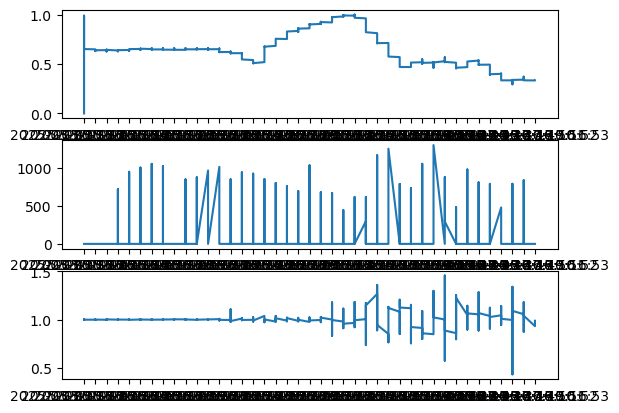

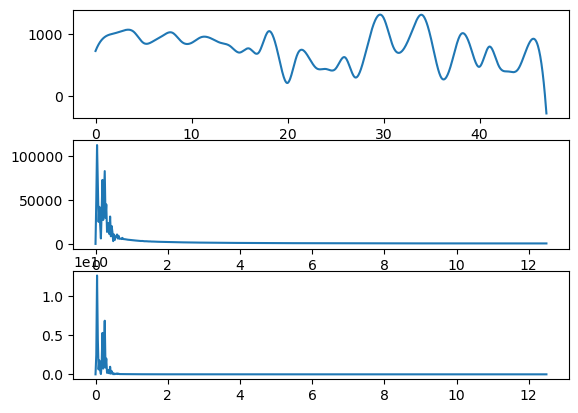

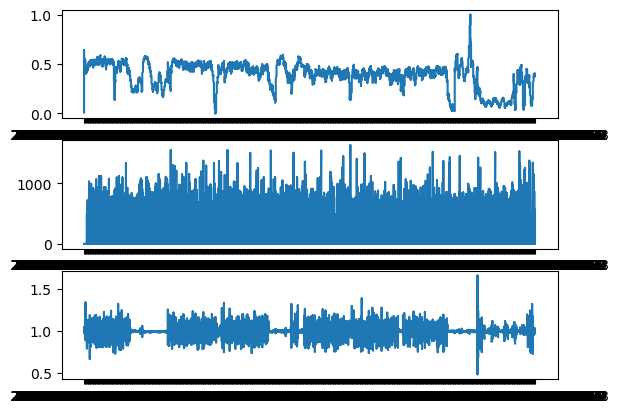

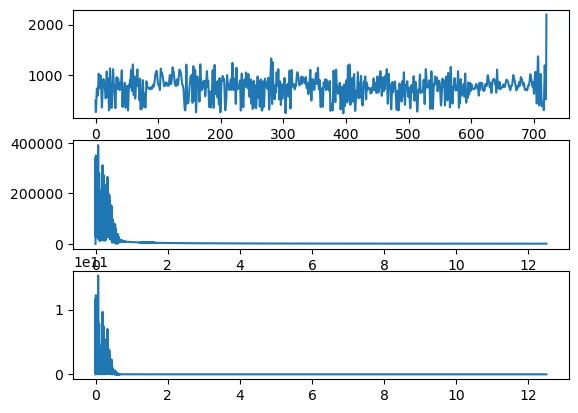

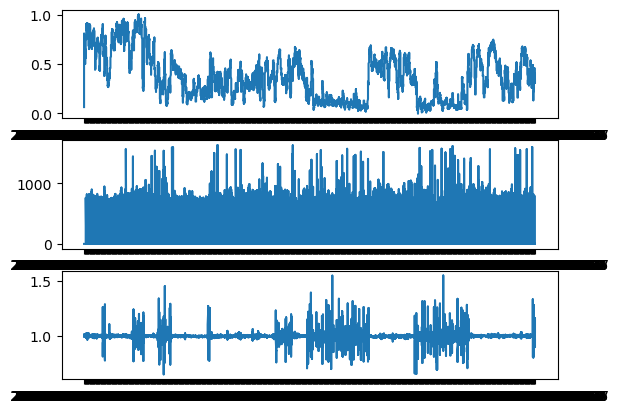

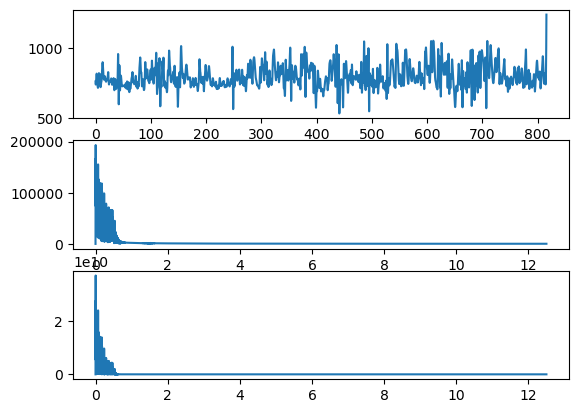

In [24]:
def make_file(): 

    #iterate through folder of files
    directory = "./data_files"

    for name in os.listdir(directory):
        
        with open(os.path.join(directory, name)) as f: 

            df = pd.read_csv(f)
            print(name)
            
            #get the data here to import right below
            [duration, RMSSD, HF, LF, ratio, total_MET] = run_processing(df)
            data = [{"index" : 'None', "duration": 'None', "RMSSD": RMSSD, "pNN50": 'None', "HF": HF, "LF": LF, "HF/LF": ratio, "MET": total_MET, "temperature": 'None', "thermal_comfort": 'None' }]
            
            #import data into file of processed data
            with open('processed_data.csv', 'a', newline = '') as csvfile:
                fieldnames = ['index', 'duration', 'RMSSD', 'pNN50', 'HF', 'LF', 'HF/LF', 'MET', 'temperature', 'thermal_comfort']
                writer = csv.DictWriter(csvfile, fieldnames= fieldnames)
                writer.writerows(data)

make_file()
